#### Neural Style Transfer using Tensorflow

In [2]:
## Import libraries
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

#### Load Pretrained VGG model

In [4]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

##### Content Cost Function

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_C,n_H*n_W])
    a_G_unrolled = tf.reshape(a_G,[n_C,n_H*n_W])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    ### END CODE HERE ###
    
    return J_content

##### Style Cost Function

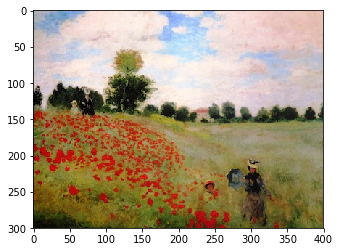

In [7]:
style_image = scipy.misc.imread("monet.jpg")
imshow(style_image)

In [8]:
## Gram matrix
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [9]:
### Style Cost
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S),[n_C, n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G),[n_C, n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = 1/(4*(n_C**2)*(n_H*n_W)**2)*tf.reduce_sum(tf.square(tf.subtract(GS,GG)))
    
    ### END CODE HERE ###
    
    return J_style_layer

In [12]:
## Style Weights
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [14]:
# Total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content + beta*J_style
    ### END CODE HERE ###
    
    return J

#### Implementation

In [22]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()


In [23]:
content_image = scipy.misc.imread("louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [24]:
style_image = scipy.misc.imread("monet.jpg")
style_image = reshape_and_normalize_image(style_image)

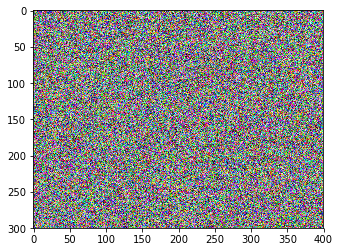

In [25]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [31]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [32]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

### START CODE HERE ### (1 line)
J = total_cost(J_content,J_style,alpha=10,beta=40)
### END CODE HERE ###

# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [40]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    init = tf.global_variables_initializer()
    sess.run(init)
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    #generated_image=sess.run(model['input'])
    #generated_image=sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 7.45749e+09
content cost = 16492.7
style cost = 1.86433e+08
Iteration 20 :
total cost = 1.98078e+09
content cost = 21247.3
style cost = 4.95141e+07
Iteration 40 :
total cost = 9.31158e+08
content cost = 23892.4
style cost = 2.3273e+07
Iteration 60 :
total cost = 6.49138e+08
content cost = 24658.2
style cost = 1.62223e+07
Iteration 80 :
total cost = 5.02779e+08
content cost = 25002.3
style cost = 1.25632e+07
Iteration 100 :
total cost = 4.10138e+08
content cost = 25228.6
style cost = 1.02471e+07
Iteration 120 :
total cost = 3.46748e+08
content cost = 25366.3
style cost = 8.66237e+06
Iteration 140 :
total cost = 3.00026e+08
content cost = 25479.5
style cost = 7.49427e+06
Iteration 160 :
total cost = 2.64812e+08
content cost = 25592.7
style cost = 6.61391e+06
Iteration 180 :
total cost = 2.36968e+08
content cost = 25677.3
style cost = 5.91779e+06
